In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
from ipywidgets import interact, FloatSlider, IntSlider, fixed, Output, widgets, interactive
from ultralytics import YOLOWorld
from skimage.morphology import skeletonize


from utils import display_images
from ui.image_viewer import view_image


### Preprocessing

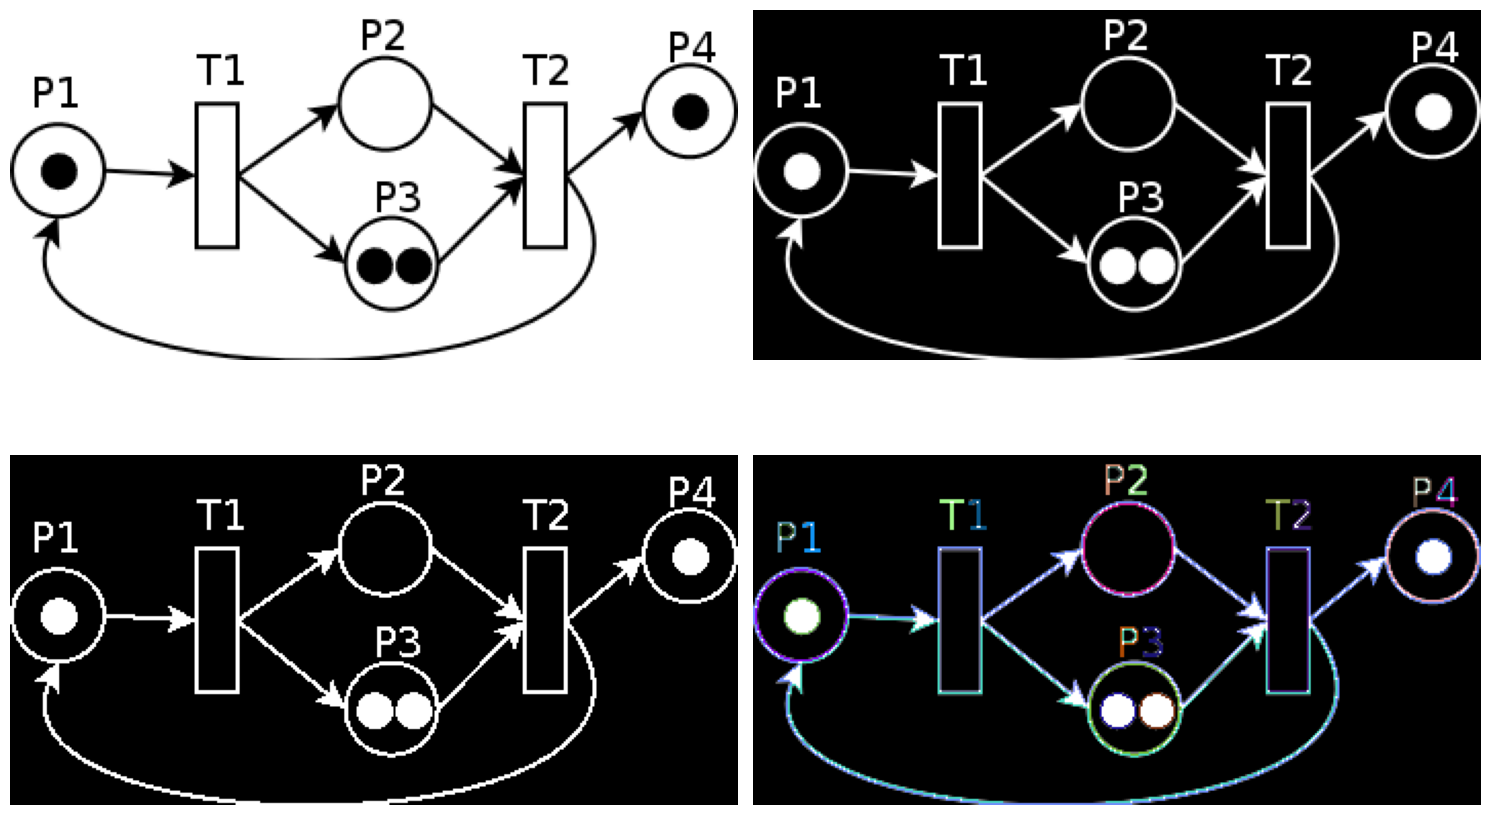

In [34]:
img_path = '../data/internet/petri_net_3.png'

img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_inverted = cv2.bitwise_not(img_gray)

_, thresh_otsu = cv2.threshold(img_inverted, 0, 255, cv2.THRESH_OTSU)
contours_list, hierarchy = cv2.findContours(thresh_otsu, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

img_contours = img_inverted.copy()
img_contours = cv2.cvtColor(img_contours, cv2.COLOR_GRAY2BGR)
for cnt in contours_list:
    cv2.drawContours(img_contours, [cnt], -1, np.random.randint(0, 255, 3).tolist(), 1)


img.shape
display_images([img_gray, img_inverted, thresh_otsu, img_contours ], rows=2)


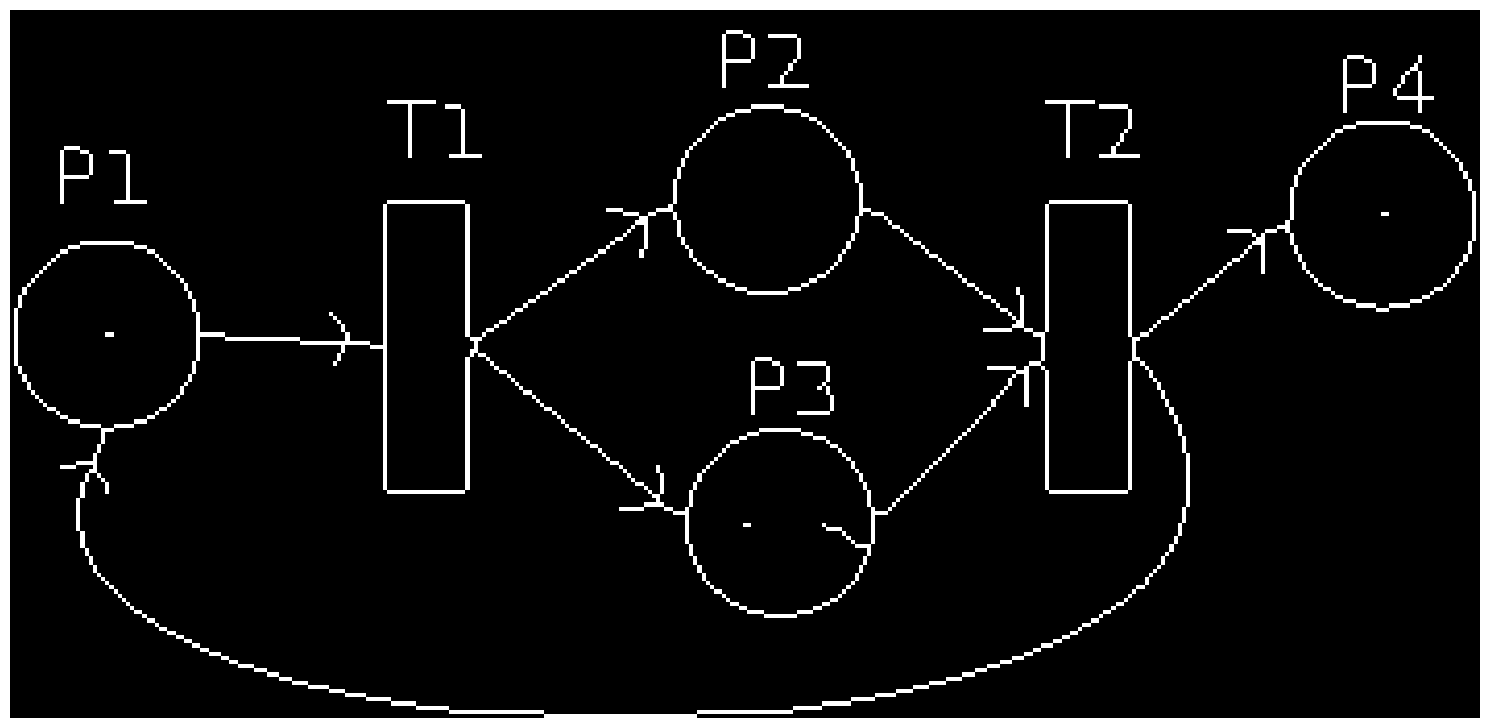

In [35]:
skeleton = skeletonize(img_inverted / 255.0)
display_images([skeleton], rows=1)

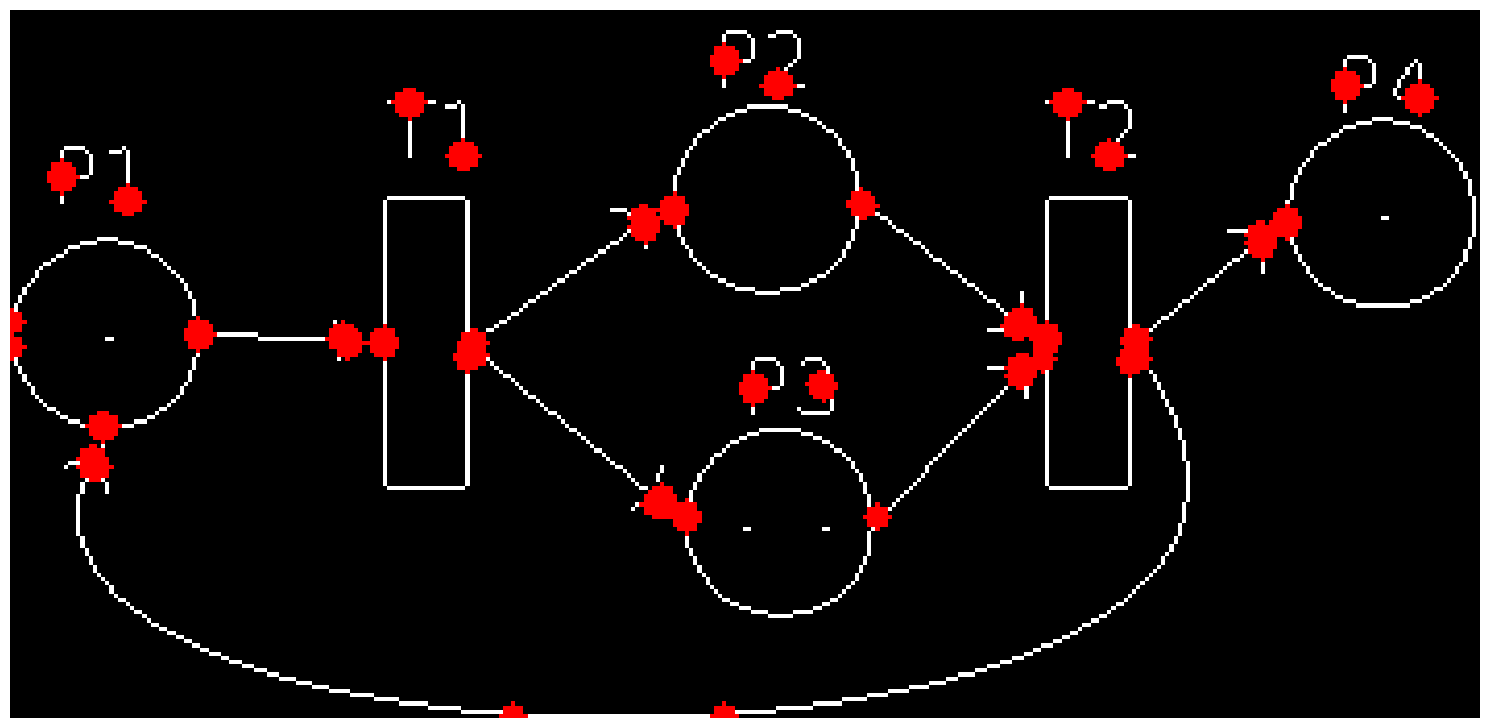

In [36]:
skeleton = skeletonize(thresh_otsu).astype(np.uint8)

# Step 4: Create a kernel to count neighbors
kernel = np.array([[1,1,1],
                   [1,10,1],
                   [1,1,1]])

# Step 5: Convolve to get neighbor counts
neighbor_count = cv2.filter2D(skeleton, -1, kernel)

# Step 6: Find junctions (value > 12 means 3+ neighbors, since center is 10)
junctions = np.where((neighbor_count > 12) & (skeleton == 1))

output = np.stack([skeleton*255]*3, axis=2) 
for y, x in zip(*junctions):
    cv2.circle(output, (x, y), 3, (0, 0, 255), -1)

display_images([output], rows=1)

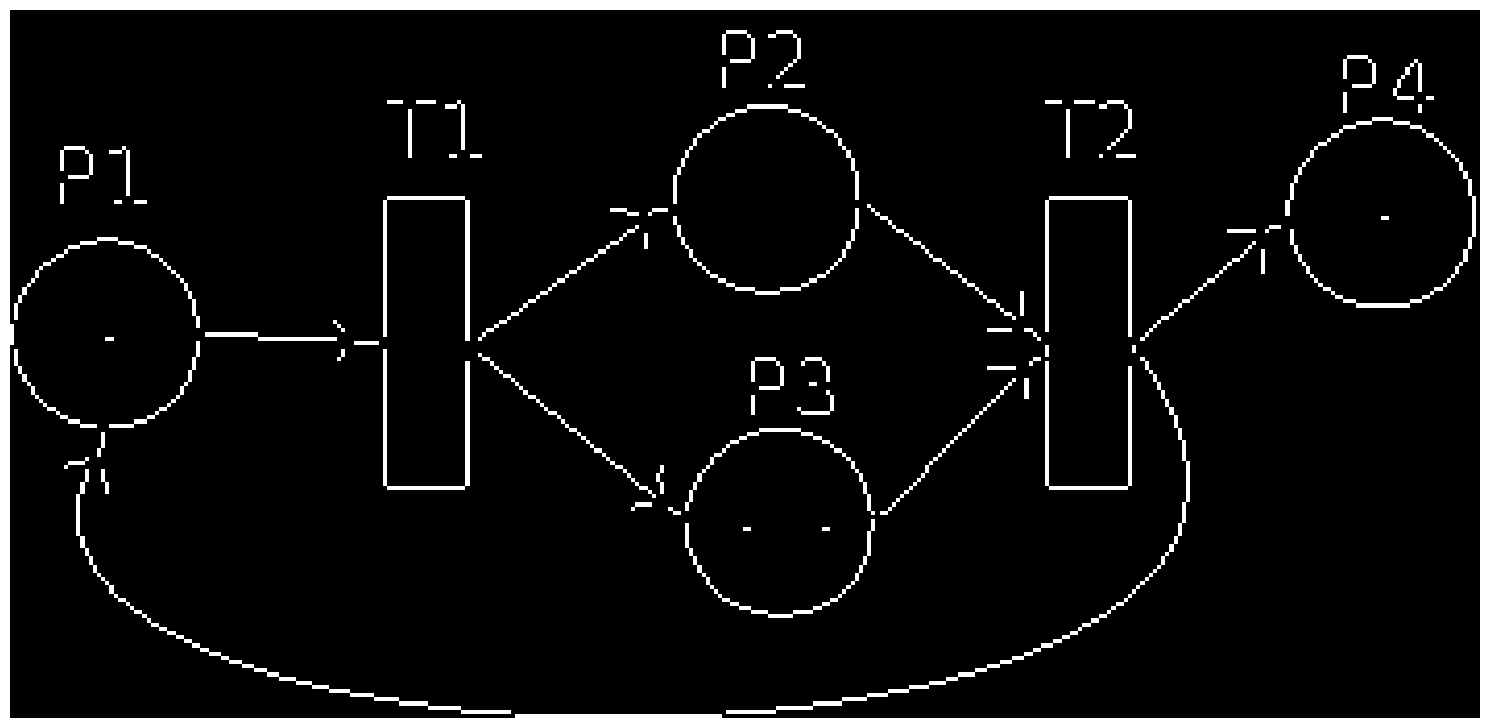

In [37]:
#substract junctions from skeleton
img_no_junctions = skeleton.copy()
img_no_junctions[junctions] = 0
display_images([img_no_junctions], rows=1)

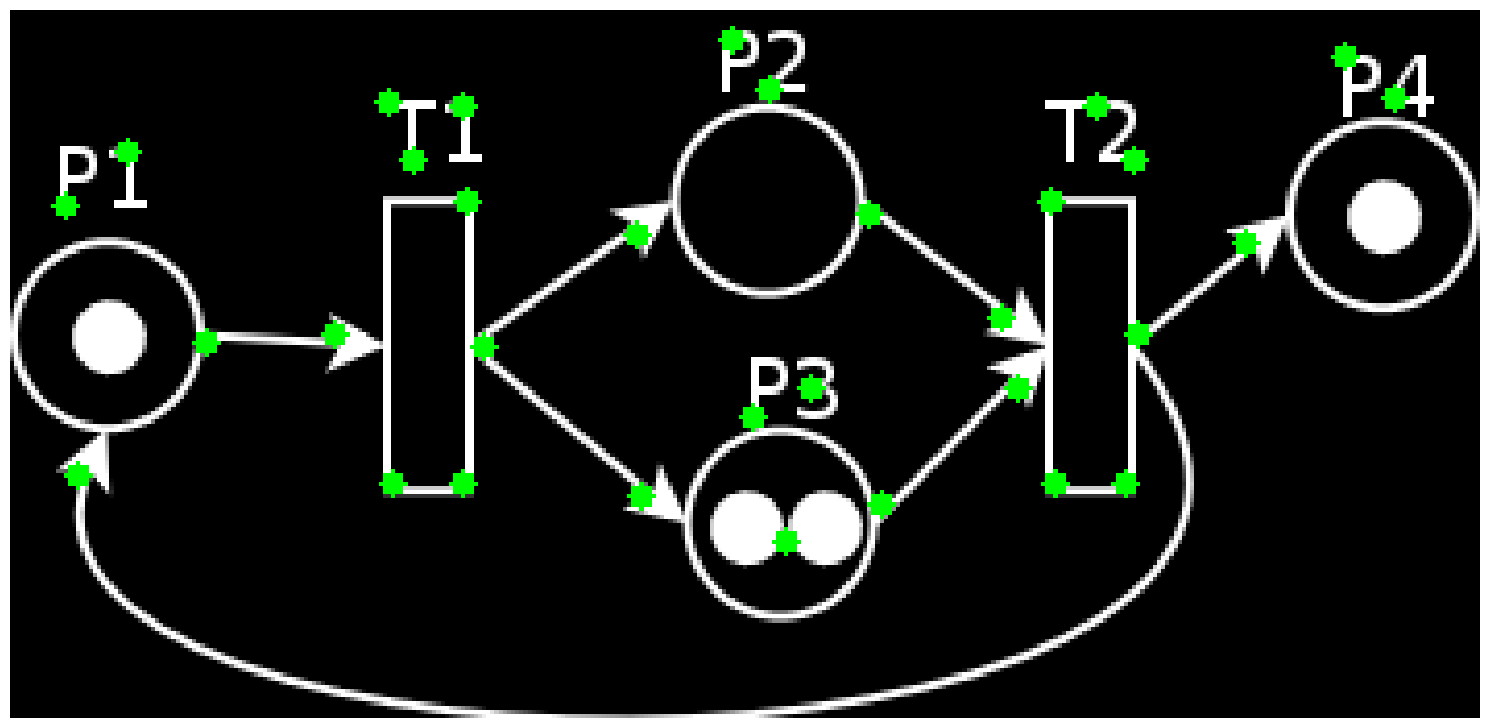

In [42]:
corners = cv2.goodFeaturesToTrack(img_inverted, len(contours_list)*4, 0.2, 15)
# cv2.cornerSubPix(img_inverted,corners,(6,6),(-1,-1),(cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS,10, 0.1))

img_corners = img_inverted.copy()
img_corners = cv2.cvtColor(img_corners, cv2.COLOR_GRAY2BGR)
for i in range(len(corners)):
    cv2.circle(img_corners, (int(corners[i][0][0]), int(corners[i][0][1])), 3, (0, 255, 0), -1)

display_images([img_corners], rows=1)

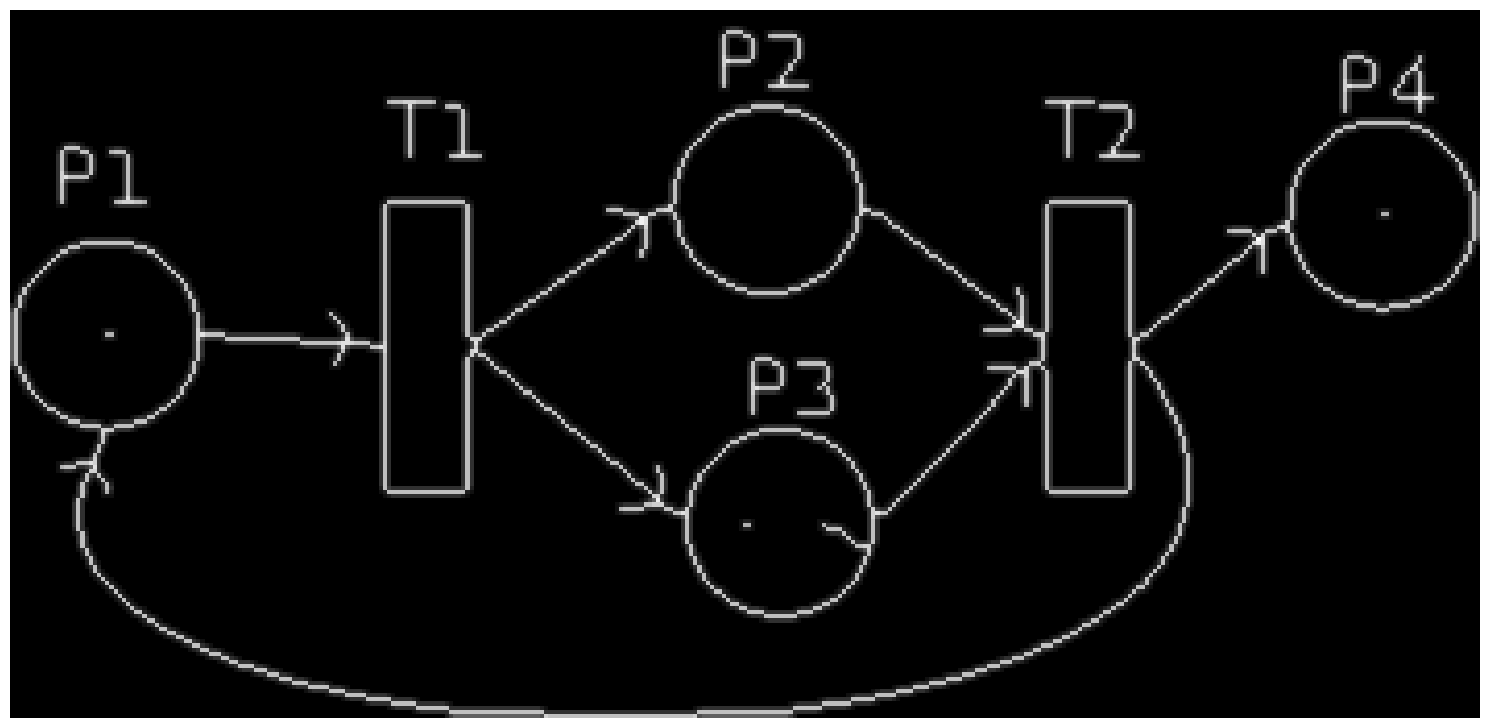

In [38]:

# Reading an image in default mode:
inputImage = img
inputImageCopy = inputImage.copy()

# Convert to grayscale:
grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)

# Compute the skeleton:
skeleton = skeletonize(img_inverted).astype(np.uint8)*255


# Threshold the image so that white pixels get a value of 10 and black pixels a value of 0:
_, binaryImage = cv2.threshold(skeleton, 128, 10, cv2.THRESH_BINARY)

# Set the convolution kernel:
h = np.array([[1, 1, 1],
              [1, 10, 1],
              [1, 1, 1]])

# Convolve the image with the kernel:
imgFiltered = cv2.filter2D(binaryImage, -1, h)

display_images([imgFiltered], rows=1)

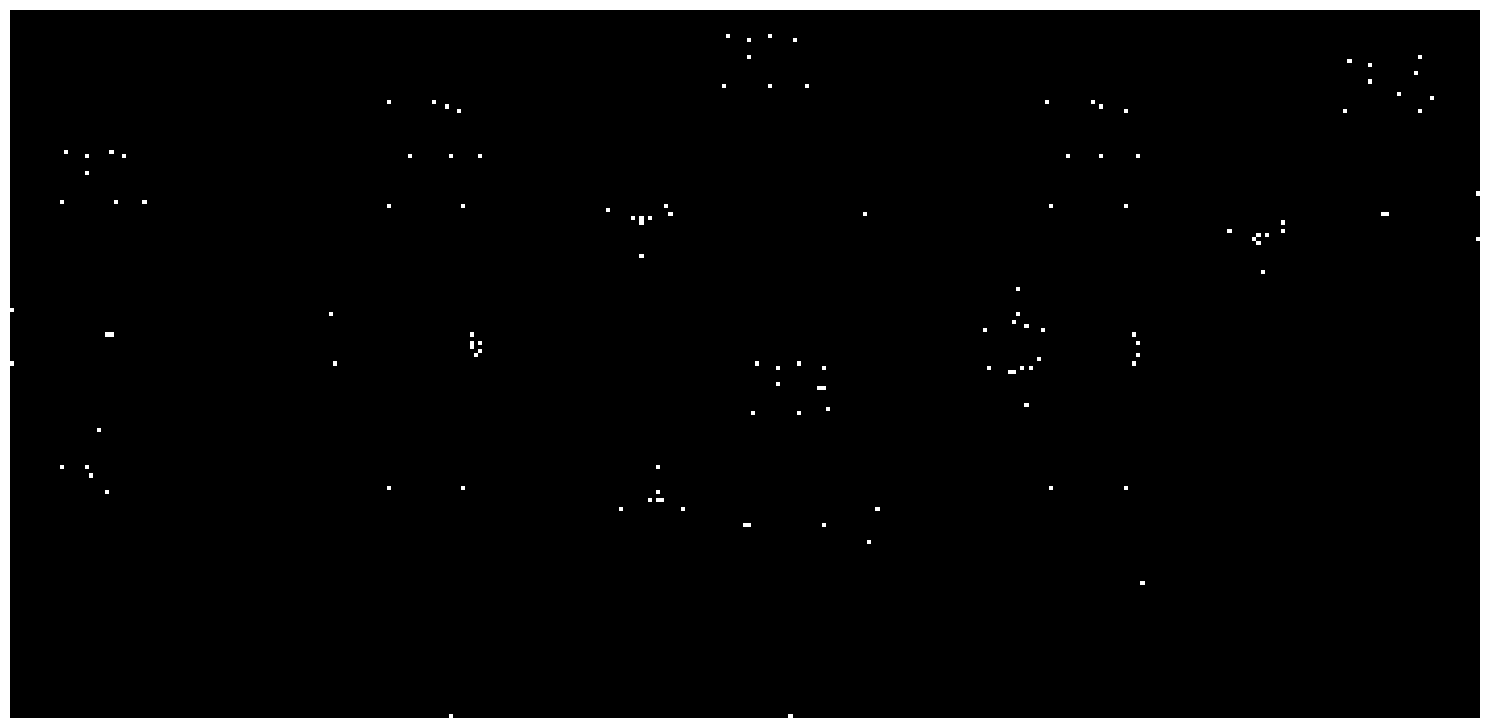

In [ ]:
# Create list of thresholds:
thresh = [130, 110, 40]

# Prepare the final mask of points:
(height, width) = binaryImage.shape
pointsMask = np.zeros((height, width, 1), np.uint8)

# Perform convolution and create points mask:
for t in range(len(thresh)):
    # Get current threshold:
    currentThresh = thresh[t]
    # Locate the threshold in the filtered image:
    tempMat = np.where(imgFiltered == currentThresh, 255, 0)
    # Convert and shape the image to a uint8 height x width x channels
    # numpy array:
    tempMat = tempMat.astype(np.uint8)
    tempMat = tempMat.reshape(height,width,1)
    # Accumulate mask:
    pointsMask = cv2.bitwise_or(pointsMask, tempMat)

# show the points mask:
display_images([pointsMask], rows=1)